In [21]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
import ast  # This is for safely converting string-lists to lists
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MultiLabelBinarizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate

# Load the NEW smart dataset
data_path = '../data/processed/processed_oven_recipes_v2.csv'
df = pd.read_csv(data_path)

# Drop any rows with missing values (just in case)
df.dropna(inplace=True)

# Let's train only on "good" recipes (rating >= 4)
df_model_data = df[df['rating'] >= 4].copy()

print(f"Loaded {len(df_model_data)} high-rated smart recipes for training.")
df_model_data.head()

Loaded 50656 high-rated smart recipes for training.


,id,name,rating,Room_Temp,Room_Humidity,ingredient_ids,tags,Oven_Temp,Oven_Duration
0,137739,arriba baked winter squash mexican style,5.000000,26.4,41.1,"[7933, 4694, 4795, 3723, 840, 5006, 6270]","['60-minutes-or-less', 'time-to-make', 'course...",350.0,40.0
2,59389,alouette potatoes,4.000000,23.2,69.7,"[1170, 4918, 6426, 5185, 7099, 5006, 6009, 627...","['60-minutes-or-less', 'time-to-make', 'course...",350.0,120.0
3,75452,beat this banana bread,4.250000,17.2,66.5,"[6906, 7367, 342, 2499, 2832, 5068, 911, 335, ...","['weeknight', 'time-to-make', 'course', 'main-...",350.0,50.0
5,25775,how i got my family to eat spinach spinach ca...,4.060241,23.0,66.8,"[2984, 2499, 6270, 590, 5010, 1168, 1674, 1974]","['60-minutes-or-less', 'time-to-make', 'course...",350.0,37.0
6,93958,i yam what i yam muffins,5.000000,29.8,52.4,"[63, 815, 7406, 332, 335, 6270, 3497, 3498, 66...","['60-minutes-or-less', 'time-to-make', 'course...",375.0,17.0


In [22]:
# --- 1. Convert String-Lists to Actual Lists ---
# The 'ingredient_ids' and 'tags' are saved as strings, e.g., "[1, 2, 3]"
# We use 'ast.literal_eval' to safely convert them back into Python lists.

print("Converting text-based lists...")
df_model_data['ingredient_ids'] = df_model_data['ingredient_ids'].apply(ast.literal_eval)
df_model_data['tags'] = df_model_data['tags'].apply(ast.literal_eval)
print("Conversion complete.")


# --- 2. Define Features (X) and Targets (Y) ---
X_name = df_model_data[['name']]
X_env = df_model_data[['Room_Temp', 'Room_Humidity']]
X_ingredients = df_model_data['ingredient_ids']
X_tags = df_model_data['tags']

Y = df_model_data[['Oven_Temp', 'Oven_Duration']]


# --- 3. Preprocess Inputs ---

# Input A: Dish Name (Same as before)
name_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_name_encoded = name_encoder.fit_transform(X_name)
num_unique_dishes = len(name_encoder.categories_[0])
print(f"Total unique dishes: {num_unique_dishes}")

# Input B: Environment (Same as before)
env_scaler = StandardScaler()
X_env_scaled = env_scaler.fit_transform(X_env)

# Input C: Ingredients (NEW!)
# We use MultiLabelBinarizer to create a "bag of words" vector
# e.g., [0, 1, 0, 1, 1, 0, ...] where a 1 means that ingredient is present.
ingredient_binarizer = MultiLabelBinarizer()
X_ingredients_encoded = ingredient_binarizer.fit_transform(X_ingredients)
num_unique_ingredients = len(ingredient_binarizer.classes_)
print(f"Total unique ingredients: {num_unique_ingredients}")

# Input D: Tags (NEW!)
# We do the same for tags.
tag_binarizer = MultiLabelBinarizer()
X_tags_encoded = tag_binarizer.fit_transform(X_tags)
num_unique_tags = len(tag_binarizer.classes_)
print(f"Total unique tags: {num_unique_tags}")


# --- 4. Preprocess Outputs (Same as before) ---
output_scaler = StandardScaler()
Y_scaled = output_scaler.fit_transform(Y)


# --- 5. Split ALL Data for Training ---
# We must split all 4 inputs and 1 output together
(X_name_train, X_name_test,
 X_env_train, X_env_test,
 X_ingr_train, X_ingr_test,
 X_tags_train, X_tags_test,
 Y_train, Y_test) = train_test_split(
    X_name_encoded,
    X_env_scaled,
    X_ingredients_encoded,
    X_tags_encoded,
    Y_scaled,
    test_size=0.2,
    random_state=42
)

print(f"\nTraining data shapes:")
print(f"Name: {X_name_train.shape}")
print(f"Env: {X_env_train.shape}")
print(f"Ingredients: {X_ingr_train.shape}")
print(f"Tags: {X_tags_train.shape}")
print(f"Outputs: {Y_train.shape}")

Converting text-based lists...
Conversion complete.
Total unique dishes: 50413
Total unique ingredients: 5841
Total unique tags: 493

Training data shapes:
Name: (40524, 1)
Env: (40524, 2)
Ingredients: (40524, 5841)
Tags: (40524, 493)
Outputs: (40524, 2)


In [23]:
# --- 1. Define Model Inputs ---
# Input A: Dish Name
name_input = Input(shape=(1,), name='name_input')
# Input B: Environment
env_input = Input(shape=(2,), name='env_input')
# Input C: Ingredients
ingredient_input = Input(shape=(num_unique_ingredients,), name='ingredient_input')
# Input D: Tags
tag_input = Input(shape=(num_unique_tags,), name='tag_input')


# --- 2. Process Each Input Branch ---
# Branch A: Dish Name (Embedding)
name_embedding = Embedding(input_dim=num_unique_dishes, output_dim=10, name='name_embedding')(name_input)
name_vec = Flatten()(name_embedding)

# Branch B: Environment (Pass-through)
env_vec = env_input

# Branch C: Ingredients (Compress the wide vector)
# We compress 2000+ ingredients down to 128 features
ingredient_vec = Dense(128, activation='relu', name='ingredient_dense')(ingredient_input)

# Branch D: Tags (Compress the wide vector)
# We compress 500+ tags down to 64 features
tag_vec = Dense(64, activation='relu', name='tag_dense')(tag_input)


# --- 3. Combine All Branches ---
combined_features = Concatenate()([name_vec, env_vec, ingredient_vec, tag_vec])


# --- 4. Model Body ---
x = Dense(128, activation='relu')(combined_features)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)


# --- 5. Define the two Output Heads ---
output_temp = Dense(1, name='temp_output')(x)
output_duration = Dense(1, name='duration_output')(x)


# --- 6. Create and Compile the Model ---
model_v2 = Model(
    inputs=[name_input, env_input, ingredient_input, tag_input], # 4 inputs
    outputs=[output_temp, output_duration] # 2 outputs
)

model_v2.compile(optimizer='adam', 
                 loss='mse', # Mean Squared Error
                 metrics={'temp_output': 'mae', 'duration_output': 'mae'}) # Mean Absolute Error

model_v2.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ name_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ name_embedding      │ (None, 1, 10)     │    504,130 │ name_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ingredient_input    │ (None, 5841)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tag_input           │ (None, 493)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 10)        │          0 │ name_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ env_input           │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ingredient_dense    │ (None, 128)       │    747,776 │ ingredient_input… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tag_dense (Dense)   │ (None, 64)        │     31,616 │ tag_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 204)       │          0 │ flatten_2[0][0],  │
│ (Concatenate)       │                   │            │ env_input[0][0],  │
│                     │                   │            │ ingredient_dense… │
│                     │                   │            │ tag_dense[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     26,240 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │      8,256 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 32)        │      2,080 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ temp_output (Dense) │ (None, 1)         │         33 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration_output     │ (None, 1)         │         33 │ dense_7[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,320,164 (5.04 MB)

 Trainable params: 1,320,164 (5.04 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
print("Starting smart model training...")

# Split the Y arrays for the two output heads
Y_temp_train = Y_train[:, 0]
Y_duration_train = Y_train[:, 1]
Y_temp_test = Y_test[:, 0]
Y_duration_test = Y_test[:, 1]

# Package the inputs and outputs as lists
X_train_list = [X_name_train, X_env_train, X_ingr_train, X_tags_train]
X_test_list = [X_name_test, X_env_test, X_ingr_test, X_tags_test]

Y_train_list = [Y_temp_train, Y_duration_train]
Y_test_list = [Y_temp_test, Y_duration_test]


history = model_v2.fit(
    X_train_list,  # List of 4 input arrays
    Y_train_list,  # List of 2 output arrays
    validation_data=(
        X_test_list,
        Y_test_list
    ),
    epochs=20, # 20 epochs is a good start
    batch_size=32,
    verbose=1
)

print("Training complete.")

Starting smart model training...
Epoch 1/20
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - duration_output_loss: 1.0021 - duration_output_mae: 0.2563 - loss: 1.7391 - temp_output_loss: 0.7363 - temp_output_mae: 0.5435 - val_duration_output_loss: 0.7535 - val_duration_output_mae: 0.2264 - val_loss: 1.3998 - val_temp_output_loss: 0.6461 - val_temp_output_mae: 0.5075
Epoch 2/20
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - duration_output_loss: 0.8812 - duration_output_mae: 0.2390 - loss: 1.3376 - temp_output_loss: 0.4558 - temp_output_mae: 0.4171 - val_duration_output_loss: 0.7775 - val_duration_output_mae: 0.2514 - val_loss: 1.4769 - val_temp_output_loss: 0.6991 - val_temp_output_mae: 0.5332
Epoch 3/20
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - duration_output_loss: 0.6272 - duration_output_mae: 0.2018 - loss: 0.8537 - temp_output_loss: 0.2261 - temp_output_mae: 0.2937 - val_duration_output_loss: 0.7631 - val_duration_output_mae: 0.2685 - val_loss: 1.4589 - val_temp_output_loss: 0.

In [25]:
# --- 1. Save the TensorFlow/Keras Model ---
model_path = '../ml_model/models/oven_predictor_v2.h5'
model_v2.save(model_path)
print(f"Smart model saved to: {model_path}")

# --- 2. Save ALL Preprocessors ---
print("Saving preprocessors...")
with open('../ml_model/models/name_encoder_v2.pkl', 'wb') as f:
    pickle.dump(name_encoder, f)
    
with open('../ml_model/models/env_scaler_v2.pkl', 'wb') as f:
    pickle.dump(env_scaler, f)
    
with open('../ml_model/models/output_scaler_v2.pkl', 'wb') as f:
    pickle.dump(output_scaler, f)
    
with open('../ml_model/models/ingredient_binarizer.pkl', 'wb') as f: # NEW
    pickle.dump(ingredient_binarizer, f)
    
with open('../ml_model/models/tag_binarizer.pkl', 'wb') as f: # NEW
    pickle.dump(tag_binarizer, f)
    
print("All v2 models and preprocessors saved.")

Smart model saved to: ../ml_model/models/oven_predictor_v2.h5
Saving preprocessors...
All v2 models and preprocessors saved.


In [26]:
# --- Let's test the full V2 prediction pipeline ---
# Get a sample row from our dataframe
test_sample = df_model_data.iloc[0] # Get the first 'good' recipe

# --- 1. Get Sample Raw Inputs ---
sample_name = [test_sample['name']]
sample_env = [[test_sample['Room_Temp'], test_sample['Room_Humidity']]]
sample_ingredients = [test_sample['ingredient_ids']] # Already a list
sample_tags = [test_sample['tags']] # Already a list

print("\n--- TEST PREDICTION ---")
print(f"Input Dish: {sample_name[0]}")

# --- 2. Process ALL 4 Inputs ---
sample_name_encoded = name_encoder.transform([sample_name])
sample_env_scaled = env_scaler.transform(sample_env)
sample_ingr_encoded = ingredient_binarizer.transform(sample_ingredients)
sample_tags_encoded = tag_binarizer.transform(sample_tags)

# 3. Package for prediction
X_pred_list = [sample_name_encoded, sample_env_scaled, sample_ingr_encoded, sample_tags_encoded]

# 4. Make Prediction
scaled_pred_temp, scaled_pred_duration = model_v2.predict(X_pred_list)

# 5. Invert Scaling (to get real-world values)
scaled_pred = np.array([[scaled_pred_temp[0][0], scaled_pred_duration[0][0]]])
final_prediction = output_scaler.inverse_transform(scaled_pred)

print(f"\n== AI V2 Prediction ==")
print(f"Predicted Temp: {final_prediction[0][0]:.0f}°F")
print(f"Predicted Duration: {final_prediction[0][1]:.0f} minutes")

print(f"\n== Actual 'Good' Value from Dataset ==")
print(f"Actual Temp: {test_sample['Oven_Temp']:.0f}°F")
print(f"Actual Duration: {test_sample['Oven_Duration']:.0f} minutes")


--- TEST PREDICTION ---
Input Dish: arriba   baked winter squash mexican style


d:\smart-oven-aiot\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but OrdinalEncoder was fitted with feature names
  warnings.warn(
d:\smart-oven-aiot\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step

== AI V2 Prediction ==
Predicted Temp: 348°F
Predicted Duration: 42 minutes

== Actual 'Good' Value from Dataset ==
Actual Temp: 350°F
Actual Duration: 40 minutes


In [27]:
# Get the MAE for the final epoch
final_temp_mae = history.history['val_temp_output_mae'][-1]
final_duration_mae = history.history['val_duration_output_mae'][-1]

print(f"Final Scaled Temp MAE: {final_temp_mae:.4f}")
print(f"Final Scaled Duration MAE: {final_duration_mae:.4f}")

# --- Convert this to real-world values ---
# We can't directly convert the MAE, but we can look at the output_scaler's scale
scale = output_scaler.scale_
print(f"\nModel predicts, on average:")
print(f"Temperature within approx. ±{final_temp_mae * scale[0]:.1f} degrees F")
print(f"Duration within approx. ±{final_duration_mae * scale[1]:.1f} minutes")

Final Scaled Temp MAE: 0.5258
Final Scaled Duration MAE: 0.2692

Model predicts, on average:
Temperature within approx. ±30.1 degrees F
Duration within approx. ±33.5 minutes


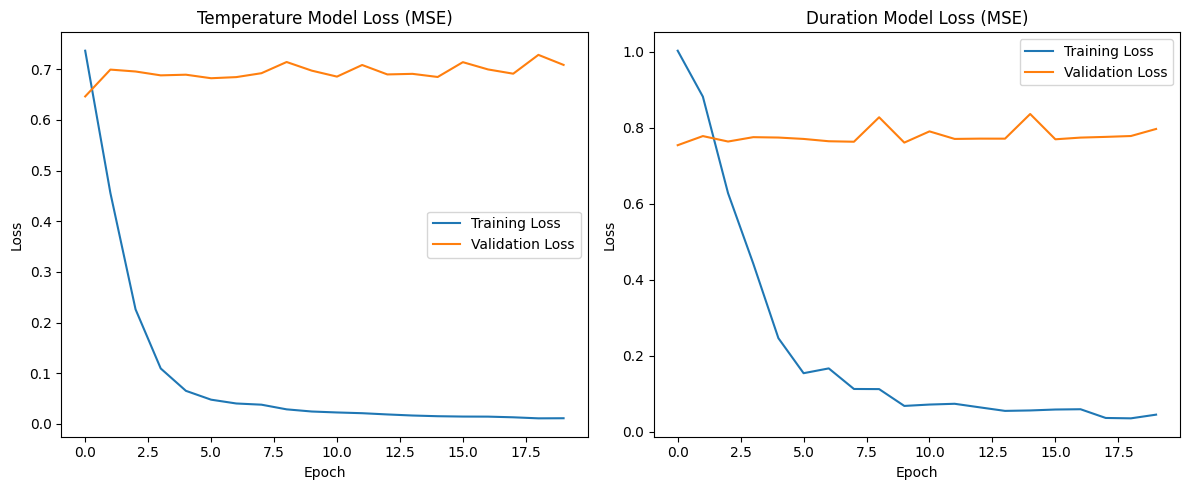

In [28]:
import matplotlib.pyplot as plt

# --- Plot 1: Temperature Loss ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['temp_output_loss'], label='Training Loss')
plt.plot(history.history['val_temp_output_loss'], label='Validation Loss')
plt.title('Temperature Model Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# --- Plot 2: Duration Loss ---
plt.subplot(1, 2, 2)
plt.plot(history.history['duration_output_loss'], label='Training Loss')
plt.plot(history.history['val_duration_output_loss'], label='Validation Loss')
plt.title('Duration Model Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()